In [1]:
import requests
import time
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
%matplotlib inline

W przykładzie będziemy szukać tweetów zawierających słowo "dama", opublikowanych w zakresie od 1 do 2 stycznia ubiegłego roku. Na podstawie tych zmiennych, generujemy link do strony wyszukiwań twittera.

In [17]:
word = 'dama'
start = '2017-12-01'
end = '2017-12-02'
language = 'pl'
url = u'https://twitter.com/search?q='+word+'%20since%3A'+start+'%20until%3A'+end+'&l='+language+'&src=typd&f=tweets'

Korzystając z selenium, ściągam odpowiedzi na moje wyszukiwanie. Twitter nie pokazuje wszystkich wyników od razu, tylko ładuje je stopniowo podczas scrollowania strony w dół - dlatego "naciskam" strzałkę dziesięć razy (w ten sposób zbieram tylko część wyników w celu demonstracji).

In [18]:
browser = webdriver.Chrome()
browser.get(url)
time.sleep(1)
body = browser.find_element_by_tag_name('body')
for _ in range(10):
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(0.2)

Zbieram treści tweetów korzystając bezpośrednio z przeglądarki. Treść tweetów to element tweet-text w kodzie HTML.

In [19]:
tweets = [tweet.text for tweet in browser.find_elements_by_class_name("tweet-text") if word in tweet.text]
len(tweets)

16

Same treści nie są jednak wystarczające, chciałabym dostać również datę publikacji. W tym celu przeszukuję źródło strony korzystając z pakietu Beautiful Soup. Dokładna data (jako unix timestamp) to atrybut data-time klasy tweet-text. 

In [20]:
tweets = list()

In [21]:
for date in browser.find_elements_by_class_name("content"):
    soup = BeautifulSoup(date.get_attribute('outerHTML'), 'lxml')
    tweet = soup.find("p", class_="tweet-text").text
    tm = int(soup.find("span", class_="_timestamp").get('data-time')) - 3600
    date = datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
    tweets.append((date, tm, tweet))

In [22]:
browser.close()

Zebrane dane (tweety i czas publikacji) wrzucam do ramki danych i na ich podstawie generuję wartości liczbowe - długość tweeta oraz czas publikacji w s.

In [23]:
df = pd.DataFrame(tweets)
df.columns = ['when', 'timestamp', 'tweet']
df['length'] = len(df['tweet'])

In [24]:
for i in range(len(df)):
    df['length'][i] = len(df['tweet'][i])
df.when = pd.to_datetime(df.when)
# df['time'] = df['when'].dt.time
# df['date'] = df['when'].dt.date
df['timestamp'] = df['timestamp'].astype(str).astype(int)
df['time_s'] = df['timestamp']%86400

C:\Users\Weronika\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Dane prezentują się następująco:

In [25]:
df.head()

,when,timestamp,tweet,length,time_s
0,2017-12-01 23:43:14,1512168194,"W wakacje jak bylam w Anglii to sie zjarałam, ...",184,81794
1,2017-12-01 22:54:52,1512165292,Prawdziwa dama pic.twitter.com/bnGXfAgdTw,41,78892
2,2017-12-01 22:40:24,1512164424,"Dama z gronostajem, olej na desce 1489r. https...",100,78024
3,2017-12-01 21:59:18,1512161958,Przecież oni nawet nie wiedzą jak wygląda dama...,113,75558
4,2017-12-01 21:08:04,1512158884,"Czemu ta ""dama"" chodzi w asyście ochrony skoro...",250,72484


Patrzę jaka jest średnia długość tweeta i mediana.

In [26]:
length_mean = int(df.length.mean())
length_median = int(df.length.median())
length_mean, length_median

(114, 90)

Konstruuję histogram rozkładu długości tweeta.

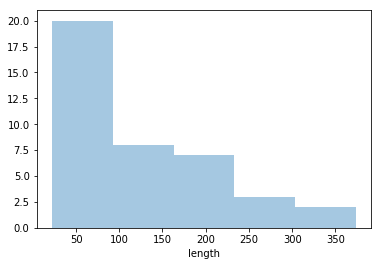

In [27]:
sns.distplot(df.length, kde = False, rug = False);

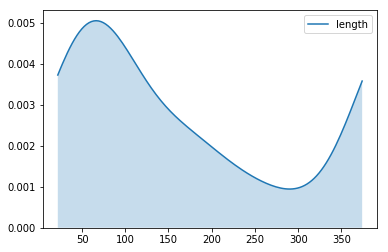

In [28]:
sns.kdeplot(df.length, shade=True, cut = 0)

Na podstawie histogramu i obliczonych wartości można stwierdzić, że wśród zebranej próbki danych przeważają krótkie wypowiedzi - może nie wszyscy zorientowali się, że limit długości wiadomości został zwiększony.

Jak wygląda korelacja czasu publikacji a długości wiadomości?

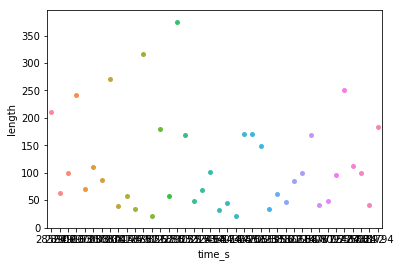

In [29]:
xmin = int(min(df.time_s)/100)*100
xmax = int(max(df.time_s)/100)*100+100
x = np.arange(xmin, xmax, 1000)
sns.swarmplot(df.time_s, df.length)

Jak prezentuje się wartość liczbowa?

In [30]:
corr = df.time_s.corr(df.length)
corr

-0.083060188093250747

Na podstawie danych nie można zabserwować wyraźniej korelacji międy czasem a długością publikacji. Dysponując szerszym zakresem czasowym (np z okresu miesiąca lub roku) można by szukać okesowych zmian zainteresowania tematem i powiązać je np z jakimś wydarzeniem krajowym. 

***

Ponadto pakiet seaborn umożliwa analizę każdej wartości liczbowej w ramce danych versus każda wartość liczbowa.

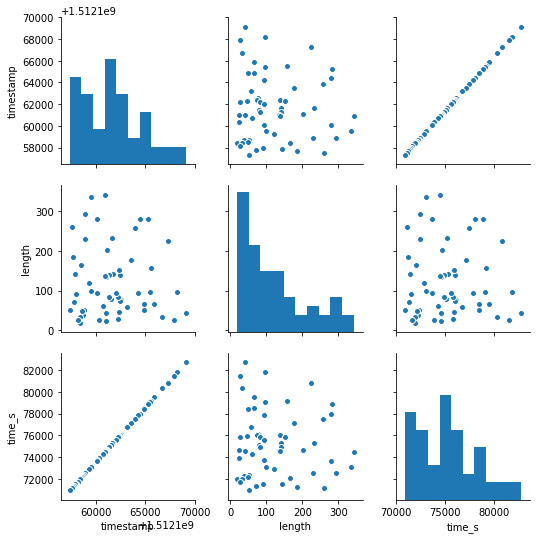

In [16]:
sns.pairplot(df)